<a href="https://colab.research.google.com/github/carlosmunoz/notebooks/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 290.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5cebfe1d6b15cf6f518b20ab4ceb3597b32b195d046c2d53281a80e7cb7e54aa
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f3c24109e17b0f5ad2be8a502d7d530612708146d6f1f100cbe0e0c04d01181e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumen

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (3/3), done.


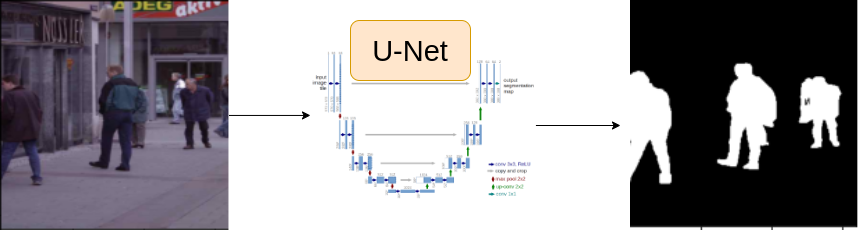

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[3]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255.0

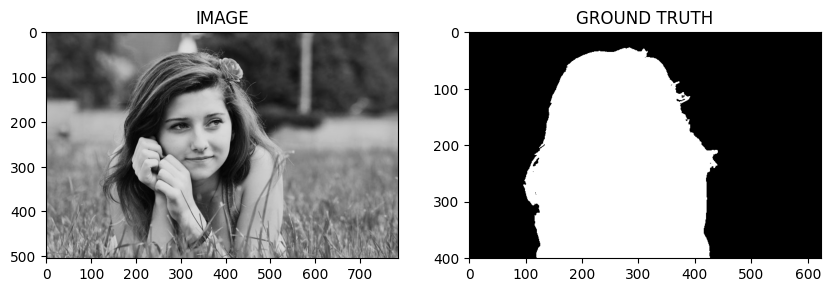

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ],
  is_check_shapes=False # need to add this for some reason
  )

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      # No need to flip the masks for some reason
  ],
  is_check_shapes=False # need to add this for some reason
  )

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
    mask = np.expand_dims(mask, axis = -1) # -> (h, w, c)

    #print(f"Image: {image.shape}")
    #print(f"Mask: {mask.shape}")
    #print(f"Image path: {image_path}")
    #print(f"Mask path: {mask_path}")

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32) # transpose from (h,w,c) -> (c,h,w)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    # transfrom from numpy to tensors
    # also scale between 0 and 1
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png


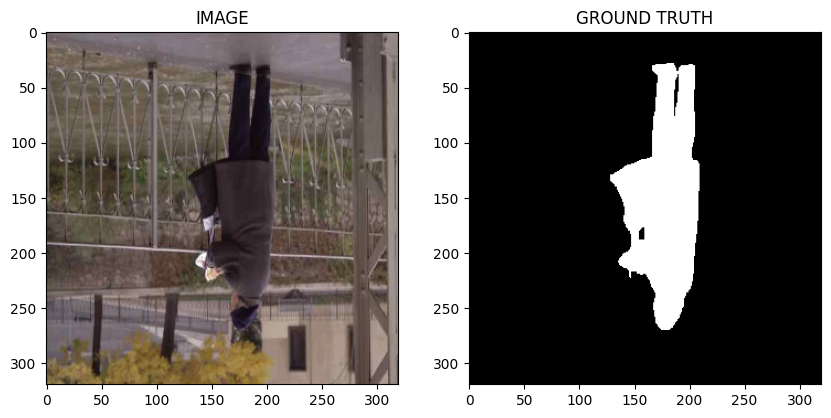

In [ ]:
idx = 4
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no of batches in train loader: {len(trainloader)}")
print(f"Total no of batches in valid loader: {len(validloader)}")

Total no of batches in train loader: 15
Total no of batches in valid loader: 4


In [ ]:
for image,mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/186.jpg
Mask path

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 391MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train() # Model will know to sue the drop out and mormalize layers
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss  += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval() # Model will switch to evaluation model
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss  += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Infinity

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED_MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/50.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/174.png
Image: (166, 303, 3)
Mask: (166, 303, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/18.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/18.png
Image: (662, 1000, 3)
Mask: (407, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/278.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/278.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/154.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/154.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask pa

  7%|▋         | 1/15 [00:00<00:07,  1.98it/s]

Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/287.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path

 13%|█▎        | 2/15 [00:01<00:06,  2.00it/s]

Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask pat

 20%|██        | 3/15 [00:01<00:05,  2.09it/s]

Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask path: H

 27%|██▋       | 4/15 [00:01<00:05,  2.14it/s]

Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/63.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/63.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask 

 33%|███▎      | 5/15 [00:02<00:04,  2.14it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/209.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask pat

 40%|████      | 6/15 [00:02<00:04,  2.15it/s]

Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/259.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask pat

 47%|████▋     | 7/15 [00:03<00:03,  2.07it/s]

Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/20.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask path:

 53%|█████▎    | 8/15 [00:03<00:03,  2.11it/s]

Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask p

 60%|██████    | 9/15 [00:04<00:02,  2.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/254.png
Image: (204, 247, 3)
Mask: (204, 247, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/19.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/19.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask pa

 67%|██████▋   | 10/15 [00:04<00:02,  1.98it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/6.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: H

 73%|███████▎  | 11/15 [00:05<00:02,  1.97it/s]

Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/274.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/185.jpg
Mask p

 80%|████████  | 12/15 [00:05<00:01,  2.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path:

 87%|████████▋ | 13/15 [00:06<00:00,  2.11it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/202.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask p

 93%|█████████▎| 14/15 [00:06<00:00,  2.12it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/125.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/37.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask pat

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/6.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: H

  7%|▋         | 1/15 [00:00<00:06,  2.20it/s]

Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask 

 13%|█▎        | 2/15 [00:00<00:05,  2.24it/s]

Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/11.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path

 20%|██        | 3/15 [00:01<00:05,  2.16it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/254.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask p

 27%|██▋       | 4/15 [00:01<00:05,  2.14it/s]

Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/51.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: H

 33%|███▎      | 5/15 [00:02<00:04,  2.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask p

 40%|████      | 6/15 [00:02<00:04,  2.20it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/91.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask 

 47%|████▋     | 7/15 [00:03<00:03,  2.15it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/270.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/287.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask 

 53%|█████▎    | 8/15 [00:03<00:03,  2.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask pat

 60%|██████    | 9/15 [00:04<00:02,  2.20it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/284.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/75.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/37.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path:

 67%|██████▋   | 10/15 [00:04<00:02,  2.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/209.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/50.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask p

 73%|███████▎  | 11/15 [00:05<00:01,  2.22it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/267.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Ma

 80%|████████  | 12/15 [00:05<00:01,  2.21it/s]

Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/174.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/2.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/2.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Huma

 87%|████████▋ | 13/15 [00:05<00:00,  2.24it/s]

Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/269.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/111.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask pa

 93%|█████████▎| 14/15 [00:06<00:00,  2.23it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/155.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/155.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask p

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.68it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask

  7%|▋         | 1/15 [00:00<00:06,  2.13it/s]

Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask pa

 13%|█▎        | 2/15 [00:00<00:06,  2.04it/s]

Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path:

 20%|██        | 3/15 [00:01<00:05,  2.01it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask

 27%|██▋       | 4/15 [00:01<00:05,  1.99it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/235.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: 

 33%|███▎      | 5/15 [00:02<00:04,  2.03it/s]

Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/82.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask pat

 40%|████      | 6/15 [00:02<00:04,  1.98it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path:

 47%|████▋     | 7/15 [00:03<00:04,  1.96it/s]

Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask pa

 53%|█████▎    | 8/15 [00:03<00:03,  2.02it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/254.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask

 60%|██████    | 9/15 [00:04<00:02,  2.06it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask

 67%|██████▋   | 10/15 [00:04<00:02,  2.08it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/6.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/37.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path:

 73%|███████▎  | 11/15 [00:05<00:01,  2.13it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask

 80%|████████  | 12/15 [00:05<00:01,  2.14it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/202.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask 

 87%|████████▋ | 13/15 [00:06<00:00,  2.19it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/20.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask pa

 93%|█████████▎| 14/15 [00:06<00:00,  2.21it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/284.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/267.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask p

 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path

  7%|▋         | 1/15 [00:00<00:06,  2.31it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (662, 1000, 3)
Mask: (407, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/278.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/278.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask p

 13%|█▎        | 2/15 [00:00<00:05,  2.25it/s]

Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path

 20%|██        | 3/15 [00:01<00:05,  2.21it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/151.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/202.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask 

 27%|██▋       | 4/15 [00:01<00:04,  2.21it/s]

Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path

 33%|███▎      | 5/15 [00:02<00:04,  2.17it/s]

Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/91.png
Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/279.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path:

 40%|████      | 6/15 [00:02<00:04,  2.15it/s]

Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask pa

 47%|████▋     | 7/15 [00:03<00:03,  2.15it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/229.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/20.png
Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/269.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/201.jpg
Mask 

 53%|█████▎    | 8/15 [00:03<00:03,  2.18it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/11.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask pat

 60%|██████    | 9/15 [00:04<00:02,  2.21it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/235.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/182.png
Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask 

 67%|██████▋   | 10/15 [00:04<00:02,  2.19it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/78.png
Image: (204, 247, 3)
Mask: (204, 247, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/19.jpg
Mask path

 73%|███████▎  | 11/15 [00:05<00:01,  2.20it/s]

Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/2.jpg
Mask 

 80%|████████  | 12/15 [00:05<00:01,  2.21it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask

 87%|████████▋ | 13/15 [00:05<00:00,  2.12it/s]

Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/219.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/219.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/116.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/116.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask 

 93%|█████████▎| 14/15 [00:06<00:00,  2.05it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/243.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/272.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask pa

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Epoch : 4 Train loss : 0.09249406903982163 Valid loss : 0.21190108358860016


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/164.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/201.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/201.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask

  7%|▋         | 1/15 [00:00<00:07,  1.77it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/275.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/37.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path

 13%|█▎        | 2/15 [00:01<00:06,  1.99it/s]

Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/287.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/171.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/49.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/49.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask pat

 20%|██        | 3/15 [00:01<00:05,  2.07it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/117.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask p

 27%|██▋       | 4/15 [00:01<00:05,  2.12it/s]

Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/45.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask 

 33%|███▎      | 5/15 [00:02<00:04,  2.08it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/50.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask pat

 40%|████      | 6/15 [00:02<00:04,  2.13it/s]

Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask path: Hu

 47%|████▋     | 7/15 [00:03<00:03,  2.16it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: H

 53%|█████▎    | 8/15 [00:03<00:03,  2.14it/s]

Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: 

 60%|██████    | 9/15 [00:04<00:02,  2.19it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/2.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/2.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: H

 67%|██████▋   | 10/15 [00:04<00:02,  2.22it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask 

 73%|███████▎  | 11/15 [00:05<00:01,  2.16it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (166, 303, 3)
Mask: (166, 303, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/18.jpg
Mask path

 80%|████████  | 12/15 [00:05<00:01,  2.16it/s]

Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/254.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path

 87%|████████▋ | 13/15 [00:06<00:00,  2.15it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/288.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/186.jpg
Mask p

 93%|█████████▎| 14/15 [00:06<00:00,  2.17it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path

 25%|██▌       | 1/4 [00:00<00:00,  4.80it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/111.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask

  7%|▋         | 1/15 [00:00<00:06,  2.19it/s]

Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/255.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/255.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/118.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/118.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask p

 13%|█▎        | 2/15 [00:00<00:05,  2.18it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/254.png
Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/75.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask pat

 20%|██        | 3/15 [00:01<00:05,  2.21it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/152.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/152.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask

 27%|██▋       | 4/15 [00:01<00:05,  2.20it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/37.png
Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask p

 33%|███▎      | 5/15 [00:02<00:04,  2.16it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask path

 40%|████      | 6/15 [00:02<00:04,  2.19it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/185.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/185.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: H

 47%|████▋     | 7/15 [00:03<00:03,  2.16it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask pat

 53%|█████▎    | 8/15 [00:03<00:03,  2.08it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/275.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/20.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask pa

 60%|██████    | 9/15 [00:04<00:02,  2.04it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path:

 67%|██████▋   | 10/15 [00:04<00:02,  1.96it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/122.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/122.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/178.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask pat

 73%|███████▎  | 11/15 [00:05<00:02,  1.93it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask 

 80%|████████  | 12/15 [00:05<00:01,  1.86it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:01,  1.77it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path:

 93%|█████████▎| 14/15 [00:07<00:00,  1.80it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask pa

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  3.26it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


SAVED_MODEL
Epoch : 6 Train loss : 0.0806938777367274 Valid loss : 0.15841981582343578


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path:

  7%|▋         | 1/15 [00:00<00:07,  1.99it/s]

Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/155.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/155.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/284.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/154.jpg
Mask

 13%|█▎        | 2/15 [00:01<00:06,  1.96it/s]

Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask p

 20%|██        | 3/15 [00:01<00:06,  1.92it/s]

Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Hu

 27%|██▋       | 4/15 [00:01<00:05,  2.04it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mas

 33%|███▎      | 5/15 [00:02<00:04,  2.11it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path

 40%|████      | 6/15 [00:02<00:04,  2.13it/s]

Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/178.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/185.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/185.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask 

 47%|████▋     | 7/15 [00:03<00:03,  2.16it/s]

Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/50.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask p

 53%|█████▎    | 8/15 [00:03<00:03,  2.16it/s]

Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/274.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask 

 60%|██████    | 9/15 [00:04<00:02,  2.17it/s]

Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Hu

 67%|██████▋   | 10/15 [00:04<00:02,  2.16it/s]

Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/125.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask pat

 73%|███████▎  | 11/15 [00:05<00:01,  2.12it/s]

Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask 

 80%|████████  | 12/15 [00:05<00:01,  2.14it/s]

Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:00,  2.13it/s]

Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/272.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path:

 93%|█████████▎| 14/15 [00:06<00:00,  2.16it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/2.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/2.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask pat

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/11.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path

  7%|▋         | 1/15 [00:00<00:06,  2.20it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask p

 13%|█▎        | 2/15 [00:00<00:05,  2.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path

 20%|██        | 3/15 [00:01<00:05,  2.16it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask

 27%|██▋       | 4/15 [00:01<00:05,  2.16it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/235.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/2.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/2.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: 

 33%|███▎      | 5/15 [00:02<00:04,  2.09it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/117.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/183.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path:

 40%|████      | 6/15 [00:02<00:04,  2.04it/s]

Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/287.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask p

 47%|████▋     | 7/15 [00:03<00:03,  2.02it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/201.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/201.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask p

 53%|█████▎    | 8/15 [00:03<00:03,  1.93it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/202.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask p

 60%|██████    | 9/15 [00:04<00:03,  1.92it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/122.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/122.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/20.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path

 67%|██████▋   | 10/15 [00:04<00:02,  1.94it/s]

Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask 

 73%|███████▎  | 11/15 [00:05<00:02,  1.98it/s]

Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/76.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/116.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/116.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/155.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/155.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask pat

 80%|████████  | 12/15 [00:05<00:01,  2.03it/s]

Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:00,  2.06it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/207.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/121.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask p

 93%|█████████▎| 14/15 [00:06<00:00,  2.10it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask pa

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (627, 1200, 3)
Mask: (361, 692, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/69.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/69.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask 

  7%|▋         | 1/15 [00:00<00:06,  2.10it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask 

 13%|█▎        | 2/15 [00:00<00:06,  2.14it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask

 20%|██        | 3/15 [00:01<00:05,  2.10it/s]

Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path:

 27%|██▋       | 4/15 [00:01<00:05,  2.12it/s]

Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path:

 33%|███▎      | 5/15 [00:02<00:04,  2.17it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/121.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask 

 40%|████      | 6/15 [00:02<00:04,  2.17it/s]

Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/171.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask p

 47%|████▋     | 7/15 [00:03<00:03,  2.18it/s]

Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/50.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/229.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path

 53%|█████▎    | 8/15 [00:03<00:03,  2.20it/s]

Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/78.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/117.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/91.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path

 60%|██████    | 9/15 [00:04<00:02,  2.18it/s]

Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Hum

 67%|██████▋   | 10/15 [00:04<00:02,  2.15it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/152.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/152.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask p

 73%|███████▎  | 11/15 [00:05<00:01,  2.18it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/243.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask p

 80%|████████  | 12/15 [00:05<00:01,  2.18it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask pa

 87%|████████▋ | 13/15 [00:06<00:00,  2.16it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: 

 93%|█████████▎| 14/15 [00:06<00:00,  2.16it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/151.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/182.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask p

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


SAVED_MODEL
Epoch : 9 Train loss : 0.0842965746919314 Valid loss : 0.15144290961325169


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/125.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path:

  7%|▋         | 1/15 [00:00<00:07,  1.96it/s]

Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask pa

 13%|█▎        | 2/15 [00:01<00:07,  1.86it/s]

Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask p

 20%|██        | 3/15 [00:01<00:06,  1.87it/s]

Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask pa

 27%|██▋       | 4/15 [00:02<00:05,  1.87it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/185.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/185.png
Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask pat

 33%|███▎      | 5/15 [00:02<00:05,  1.98it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (639, 1000, 3)
Mask: (400, 625, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/265.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/265.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/285.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask 

 40%|████      | 6/15 [00:03<00:04,  2.05it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask

 47%|████▋     | 7/15 [00:03<00:03,  2.02it/s]

Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask pat

 53%|█████▎    | 8/15 [00:04<00:03,  2.06it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/243.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mas

 60%|██████    | 9/15 [00:04<00:02,  2.11it/s]

Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/82.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path:

 67%|██████▋   | 10/15 [00:04<00:02,  2.12it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/171.png
Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask 

 73%|███████▎  | 11/15 [00:05<00:01,  2.15it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask pat

 80%|████████  | 12/15 [00:05<00:01,  2.19it/s]

Image: (204, 247, 3)
Mask: (204, 247, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/19.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/19.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/111.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path:

 87%|████████▋ | 13/15 [00:06<00:00,  2.20it/s]

Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/49.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/49.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: 

 93%|█████████▎| 14/15 [00:06<00:00,  2.17it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/288.png
Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/51.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask pa

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/275.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path:

  7%|▋         | 1/15 [00:00<00:06,  2.11it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/91.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path

 13%|█▎        | 2/15 [00:00<00:05,  2.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask pat

 20%|██        | 3/15 [00:01<00:05,  2.18it/s]

Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/171.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask pa

 27%|██▋       | 4/15 [00:01<00:05,  2.14it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask p

 33%|███▎      | 5/15 [00:02<00:04,  2.15it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/82.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/154.jpg
Mask p

 40%|████      | 6/15 [00:02<00:04,  2.11it/s]

Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/207.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask 

 47%|████▋     | 7/15 [00:03<00:03,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/164.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path

 53%|█████▎    | 8/15 [00:03<00:03,  2.14it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask pat

 60%|██████    | 9/15 [00:04<00:02,  2.14it/s]

Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path:

 67%|██████▋   | 10/15 [00:04<00:02,  2.05it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask pa

 73%|███████▎  | 11/15 [00:05<00:01,  2.02it/s]

Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/269.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/186.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/186.png
Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mas

 80%|████████  | 12/15 [00:05<00:01,  2.00it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/209.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:01,  1.98it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask pat

 93%|█████████▎| 14/15 [00:06<00:00,  1.96it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/20.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path:

  7%|▋         | 1/15 [00:00<00:06,  2.01it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/243.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask p

 13%|█▎        | 2/15 [00:00<00:06,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path

 20%|██        | 3/15 [00:01<00:05,  2.17it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask

 27%|██▋       | 4/15 [00:01<00:05,  2.18it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path:

 33%|███▎      | 5/15 [00:02<00:04,  2.16it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Ma

 40%|████      | 6/15 [00:02<00:04,  2.13it/s]

Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: H

 47%|████▋     | 7/15 [00:03<00:03,  2.18it/s]

Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/287.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/274.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask pa

 53%|█████▎    | 8/15 [00:03<00:03,  2.17it/s]

Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (662, 1000, 3)
Mask: (407, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/278.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/278.png
Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask 

 60%|██████    | 9/15 [00:04<00:02,  2.15it/s]

Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/279.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask p

 67%|██████▋   | 10/15 [00:04<00:02,  2.15it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/118.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/118.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask path:

 73%|███████▎  | 11/15 [00:05<00:01,  2.16it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/117.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/219.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/219.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: 

 80%|████████  | 12/15 [00:05<00:01,  2.15it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:00,  2.14it/s]

Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: 

 93%|█████████▎| 14/15 [00:06<00:00,  2.16it/s]

Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/6.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/11.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: H

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/164.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask

  7%|▋         | 1/15 [00:00<00:06,  2.13it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Hum

 13%|█▎        | 2/15 [00:00<00:05,  2.21it/s]

Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/58.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask p

 20%|██        | 3/15 [00:01<00:05,  2.14it/s]

Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/279.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask 

 27%|██▋       | 4/15 [00:01<00:05,  1.98it/s]

Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask 

 33%|███▎      | 5/15 [00:02<00:05,  1.93it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/182.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path:

 40%|████      | 6/15 [00:03<00:04,  1.88it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask p

 47%|████▋     | 7/15 [00:03<00:04,  1.82it/s]

Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/6.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/186.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/186.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: 

 53%|█████▎    | 8/15 [00:04<00:03,  1.86it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: Hu

 60%|██████    | 9/15 [00:04<00:03,  1.90it/s]

Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask p

 67%|██████▋   | 10/15 [00:05<00:02,  1.97it/s]

Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mas

 73%|███████▎  | 11/15 [00:05<00:01,  2.05it/s]

Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/125.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: H

 80%|████████  | 12/15 [00:06<00:01,  2.08it/s]

Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:00,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask 

 93%|█████████▎| 14/15 [00:06<00:00,  2.15it/s]

Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/183.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask pat

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

Epoch : 13 Train loss : 0.0653445266187191 Valid loss : 0.1729409284889698


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/63.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/63.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/76.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Hu

  7%|▋         | 1/15 [00:00<00:06,  2.05it/s]

Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/288.png
Image: (166, 303, 3)
Mask: (166, 303, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/18.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/18.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask p

 13%|█▎        | 2/15 [00:00<00:06,  2.06it/s]

Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/155.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/155.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask 

 20%|██        | 3/15 [00:01<00:05,  2.03it/s]

Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask pa

 27%|██▋       | 4/15 [00:01<00:05,  2.08it/s]

Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/274.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/269.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask

 33%|███▎      | 5/15 [00:02<00:04,  2.07it/s]

Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/6.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Hu

 40%|████      | 6/15 [00:02<00:04,  2.10it/s]

Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/151.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path:

 47%|████▋     | 7/15 [00:03<00:03,  2.13it/s]

Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/275.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path:

 53%|█████▎    | 8/15 [00:03<00:03,  1.96it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/118.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/118.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask

 60%|██████    | 9/15 [00:04<00:02,  2.04it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/117.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask pat

 67%|██████▋   | 10/15 [00:04<00:02,  2.09it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/174.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/178.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/20.jpg
Mask path: 

 73%|███████▎  | 11/15 [00:05<00:01,  2.15it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/182.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/45.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/82.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask pat

 80%|████████  | 12/15 [00:05<00:01,  2.14it/s]

Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: 

 87%|████████▋ | 13/15 [00:06<00:00,  2.15it/s]

Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/11.png
Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: 

 93%|█████████▎| 14/15 [00:06<00:00,  2.18it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask pat

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Epoch : 14 Train loss : 0.06769244248668353 Valid loss : 0.15937132388353348


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/285.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: 

  7%|▋         | 1/15 [00:00<00:07,  1.84it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mas

 13%|█▎        | 2/15 [00:01<00:07,  1.85it/s]

Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/270.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/45.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/17.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/255.jpg
Mask pat

 20%|██        | 3/15 [00:01<00:06,  1.88it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/49.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/49.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path:

 27%|██▋       | 4/15 [00:02<00:05,  2.02it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask pa

 33%|███▎      | 5/15 [00:02<00:04,  2.05it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/51.png
Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/152.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/152.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask p

 40%|████      | 6/15 [00:02<00:04,  2.07it/s]

Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path:

 47%|████▋     | 7/15 [00:03<00:03,  2.12it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/272.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask pa

 53%|█████▎    | 8/15 [00:03<00:03,  2.10it/s]

Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/122.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/122.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask pa

 60%|██████    | 9/15 [00:04<00:02,  2.09it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/207.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (639, 1000, 3)
Mask: (400, 625, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/265.jpg
Mask path

 67%|██████▋   | 10/15 [00:04<00:02,  2.12it/s]

Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/183.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/164.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask p

 73%|███████▎  | 11/15 [00:05<00:01,  2.15it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/116.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/116.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/155.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/155.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/186.jpg
Mask

 80%|████████  | 12/15 [00:05<00:01,  2.15it/s]

Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path

 87%|████████▋ | 13/15 [00:06<00:00,  2.14it/s]

Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask

 93%|█████████▎| 14/15 [00:06<00:00,  2.08it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path:

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask

  7%|▋         | 1/15 [00:00<00:07,  1.90it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask p

 13%|█▎        | 2/15 [00:01<00:06,  1.98it/s]

Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/219.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/219.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask 

 20%|██        | 3/15 [00:01<00:05,  2.00it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (166, 303, 3)
Mask: (166, 303, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/18.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/18.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask pat

 27%|██▋       | 4/15 [00:01<00:05,  2.08it/s]

Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/51.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path

 33%|███▎      | 5/15 [00:02<00:04,  2.12it/s]

Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: H

 40%|████      | 6/15 [00:02<00:04,  2.18it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask pat

 47%|████▋     | 7/15 [00:03<00:03,  2.17it/s]

Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/91.png
Image: (204, 247, 3)
Mask: (204, 247, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/19.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/19.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/75.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: H

 53%|█████▎    | 8/15 [00:03<00:03,  2.18it/s]

Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/171.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask pa

 60%|██████    | 9/15 [00:04<00:02,  2.10it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path

 67%|██████▋   | 10/15 [00:04<00:02,  2.04it/s]

Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path

 73%|███████▎  | 11/15 [00:05<00:02,  1.93it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: H

 80%|████████  | 12/15 [00:05<00:01,  1.89it/s]

Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/272.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/78.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask 

 87%|████████▋ | 13/15 [00:06<00:01,  1.83it/s]

Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/183.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask p

 93%|█████████▎| 14/15 [00:07<00:00,  1.84it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/58.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Hum

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

Epoch : 16 Train loss : 0.06867846598227818 Valid loss : 0.15816565416753292


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (627, 1200, 3)
Mask: (361, 692, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/69.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/69.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask 

  7%|▋         | 1/15 [00:00<00:06,  2.01it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/63.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/63.png
Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/82.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path

 13%|█▎        | 2/15 [00:00<00:06,  2.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask pa

 20%|██        | 3/15 [00:01<00:05,  2.06it/s]

Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/125.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/178.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask pat

 27%|██▋       | 4/15 [00:01<00:05,  2.13it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask pa

 33%|███▎      | 5/15 [00:02<00:04,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/259.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask p

 40%|████      | 6/15 [00:02<00:04,  2.12it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path:

 47%|████▋     | 7/15 [00:03<00:03,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask pa

 53%|█████▎    | 8/15 [00:03<00:03,  2.14it/s]

Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/122.jpg
Mask path:

 60%|██████    | 9/15 [00:04<00:02,  2.16it/s]

Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask pa

 67%|██████▋   | 10/15 [00:04<00:02,  2.17it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask path:

 73%|███████▎  | 11/15 [00:05<00:01,  2.20it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/274.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask pa

 80%|████████  | 12/15 [00:05<00:01,  2.18it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/267.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask p

 87%|████████▋ | 13/15 [00:06<00:00,  2.07it/s]

Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/182.png
Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask pa

 93%|█████████▎| 14/15 [00:06<00:00,  2.10it/s]

Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/284.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/288.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask pat

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Epoch : 17 Train loss : 0.06760517309109369 Valid loss : 0.16508803889155388


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask pat

  7%|▋         | 1/15 [00:00<00:06,  2.09it/s]

Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/75.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/202.png
Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/78.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path:

 13%|█▎        | 2/15 [00:00<00:06,  2.10it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/186.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/186.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (166, 303, 3)
Mask: (166, 303, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/18.jpg
Mask 

 20%|██        | 3/15 [00:01<00:05,  2.09it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/7.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask path: Hum

 27%|██▋       | 4/15 [00:02<00:06,  1.81it/s]

Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/121.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/219.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/219.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path

 33%|███▎      | 5/15 [00:02<00:05,  1.73it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (315, 391, 3)
Mask: (315, 391, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/91.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/91.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask pa

 40%|████      | 6/15 [00:03<00:05,  1.74it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask p

 47%|████▋     | 7/15 [00:03<00:04,  1.76it/s]

Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/279.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path

 53%|█████▎    | 8/15 [00:04<00:03,  1.82it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/229.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/172.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/172.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask

 60%|██████    | 9/15 [00:04<00:03,  1.91it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: H

 67%|██████▋   | 10/15 [00:05<00:02,  2.00it/s]

Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/300.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/178.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask p

 73%|███████▎  | 11/15 [00:05<00:01,  2.02it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/51.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/259.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask pat

 80%|████████  | 12/15 [00:06<00:01,  2.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/182.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/111.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask p

 87%|████████▋ | 13/15 [00:06<00:00,  2.08it/s]

Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path

 93%|█████████▎| 14/15 [00:07<00:00,  2.09it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/245.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask pa

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


SAVED_MODEL
Epoch : 18 Train loss : 0.06651442671815554 Valid loss : 0.13935861364006996


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask 

  7%|▋         | 1/15 [00:00<00:06,  2.02it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/196.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask p

 13%|█▎        | 2/15 [00:00<00:06,  2.03it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask p

 20%|██        | 3/15 [00:01<00:05,  2.05it/s]

Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path

 27%|██▋       | 4/15 [00:01<00:05,  2.10it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/243.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask p

 33%|███▎      | 5/15 [00:02<00:04,  2.14it/s]

Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/219.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/219.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/58.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path

 40%|████      | 6/15 [00:02<00:04,  2.16it/s]

Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/76.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask pat

 47%|████▋     | 7/15 [00:03<00:03,  2.14it/s]

Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/212.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/212.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path:

 53%|█████▎    | 8/15 [00:03<00:03,  2.17it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/116.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/116.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/234.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask p

 60%|██████    | 9/15 [00:04<00:02,  2.18it/s]

Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/207.png
Image: (180, 300, 3)
Mask: (180, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/96.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/96.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask pat

 67%|██████▋   | 10/15 [00:04<00:02,  2.18it/s]

Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/164.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/164.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/22.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/22.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/118.jpg
Mask path

 73%|███████▎  | 11/15 [00:05<00:01,  2.15it/s]

Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask pat

 80%|████████  | 12/15 [00:05<00:01,  2.11it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/53.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask pa

 87%|████████▋ | 13/15 [00:06<00:00,  2.11it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask pa

 93%|█████████▎| 14/15 [00:06<00:00,  2.08it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/62.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask pat

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  3.41it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Epoch : 19 Train loss : 0.062251609812180204 Valid loss : 0.1808679923415184


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (916, 960, 3)
Mask: (488, 512, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/272.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/272.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (639, 1000, 3)
Mask: (400, 625, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/265.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/265.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/38.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask pa

  7%|▋         | 1/15 [00:00<00:08,  1.68it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/207.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask p

 13%|█▎        | 2/15 [00:01<00:07,  1.86it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/45.png
Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask pa

 20%|██        | 3/15 [00:01<00:06,  1.98it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/279.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: H

 27%|██▋       | 4/15 [00:02<00:05,  2.03it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask 

 33%|███▎      | 5/15 [00:02<00:04,  2.07it/s]

Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/267.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/125.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (657, 1168, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/300.jpg
Mas

 40%|████      | 6/15 [00:02<00:04,  2.05it/s]

Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/108.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask path: 

 47%|████▋     | 7/15 [00:03<00:03,  2.08it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/123.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/123.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/122.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/122.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/255.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/255.png
Image: (1024, 683, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/269.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/269.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/238.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/238.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mas

 53%|█████▎    | 8/15 [00:03<00:03,  2.09it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask p

 60%|██████    | 9/15 [00:04<00:02,  2.13it/s]

Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask pat

 67%|██████▋   | 10/15 [00:04<00:02,  2.13it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/111.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/245.jpg
Mask p

 73%|███████▎  | 11/15 [00:05<00:01,  2.14it/s]

Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/270.png
Image: (204, 247, 3)
Mask: (204, 247, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/19.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/19.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask 

 80%|████████  | 12/15 [00:05<00:01,  2.13it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path:

 87%|████████▋ | 13/15 [00:06<00:00,  2.13it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path: Human

 93%|█████████▎| 14/15 [00:06<00:00,  2.16it/s]

Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path:

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

Epoch : 20 Train loss : 0.06028080756465594 Valid loss : 0.14514999091625214


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/154.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/154.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask p

  7%|▋         | 1/15 [00:00<00:06,  2.02it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/58.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/207.jpg
Mask pat

 13%|█▎        | 2/15 [00:00<00:06,  2.15it/s]

Image: (450, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/280.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/280.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask p

 20%|██        | 3/15 [00:01<00:05,  2.17it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/174.png
Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/78.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (662, 1000, 3)
Mask: (407, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/278.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/278.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask pa

 27%|██▋       | 4/15 [00:01<00:05,  2.11it/s]

Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (162, 311, 3)
Mask: (162, 311, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/37.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/37.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path:

 33%|███▎      | 5/15 [00:02<00:04,  2.10it/s]

Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/75.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/124.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/184.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/184.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask pat

 40%|████      | 6/15 [00:02<00:04,  2.10it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path:

 47%|████▋     | 7/15 [00:03<00:03,  2.08it/s]

Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/178.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/178.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/288.png
Image: (222, 227, 3)
Mask: (222, 227, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/99.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/99.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask path

 53%|█████▎    | 8/15 [00:03<00:03,  2.05it/s]

Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/284.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/252.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/252.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path

 60%|██████    | 9/15 [00:04<00:02,  2.05it/s]

Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/246.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/246.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask 

 67%|██████▋   | 10/15 [00:04<00:02,  1.92it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask pat

 73%|███████▎  | 11/15 [00:05<00:02,  1.89it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/267.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (163, 310, 3)
Mask: (163, 310, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/25.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/25.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask p

 80%|████████  | 12/15 [00:06<00:01,  1.80it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/222.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/222.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/148.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/148.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/234.jpg
Mask

 87%|████████▋ | 13/15 [00:06<00:01,  1.82it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/116.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/116.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/275.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/229.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/122.jpg
Mask p

 93%|█████████▎| 14/15 [00:07<00:00,  1.91it/s]

Image: (413, 620, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/276.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/276.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask 

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


Epoch : 21 Train loss : 0.054779700189828875 Valid loss : 0.1546490229666233


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (467, 830, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/55.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/55.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask pat

  7%|▋         | 1/15 [00:00<00:06,  2.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/197.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/197.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask

 13%|█▎        | 2/15 [00:00<00:06,  2.09it/s]

Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/227.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/227.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/23.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/23.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path

 20%|██        | 3/15 [00:01<00:05,  2.15it/s]

Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (167, 301, 3)
Mask: (167, 301, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/21.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/21.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/209.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask pat

 27%|██▋       | 4/15 [00:01<00:05,  2.12it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/135.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/135.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/259.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/24.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/24.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/121.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/121.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/253.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/253.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask p

 33%|███▎      | 5/15 [00:02<00:04,  2.11it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (204, 247, 3)
Mask: (204, 247, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/19.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/19.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path:

 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/73.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/235.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/192.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/7.jpg
Mask path: H

 47%|████▋     | 7/15 [00:03<00:03,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (150, 335, 3)
Mask: (150, 335, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/31.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/31.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (417, 626, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/266.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/266.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask p

 53%|█████▎    | 8/15 [00:03<00:03,  2.13it/s]

Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/45.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/270.png
Image: (734, 1100, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/53.jpg
Mask path

 60%|██████    | 9/15 [00:04<00:02,  2.09it/s]

Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/177.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/177.png
Image: (427, 640, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/191.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/191.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/168.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/168.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mas

 67%|██████▋   | 10/15 [00:04<00:02,  2.10it/s]

Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/60.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/60.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/134.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/134.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/47.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/47.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/132.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask path: Hu

 73%|███████▎  | 11/15 [00:05<00:01,  2.12it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask pa

 80%|████████  | 12/15 [00:05<00:01,  2.13it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/193.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/193.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: 

 87%|████████▋ | 13/15 [00:06<00:00,  2.12it/s]

Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/285.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/233.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/233.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/214.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/214.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask p

 93%|█████████▎| 14/15 [00:06<00:00,  2.11it/s]

Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/152.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/152.png
Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask p

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch : 22 Train loss : 0.053237488865852355 Valid loss : 0.15957926586270332


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/202.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/202.png
Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (398, 600, 3)
Mask: (398, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/268.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/268.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (320, 590, 3)
Mask: (320, 590, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/62.jpg
Mask path

  7%|▋         | 1/15 [00:00<00:06,  2.03it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/192.jpg
Mask pa

 13%|█▎        | 2/15 [00:01<00:07,  1.79it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/225.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/225.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/224.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/224.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/147.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/147.png
Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (580, 880, 3)
Mask: (406, 616, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/78.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/78.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/108.jpg
Mask pat

 20%|██        | 3/15 [00:01<00:06,  1.82it/s]

Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/133.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/220.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/251.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/251.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/94.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/94.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask pa

 27%|██▋       | 4/15 [00:02<00:05,  1.86it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/139.png
Image: (662, 1000, 3)
Mask: (407, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/278.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/278.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/165.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/151.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask

 33%|███▎      | 5/15 [00:02<00:05,  1.90it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/150.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/150.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask p

 40%|████      | 6/15 [00:03<00:04,  1.93it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask pat

 47%|████▋     | 7/15 [00:03<00:04,  1.91it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/142.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/76.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/76.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (437, 700, 3)
Mask: (395, 633, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/284.jpg
Mask pa

 53%|█████▎    | 8/15 [00:04<00:03,  1.97it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/285.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/185.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/185.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/254.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/254.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask pat

 60%|██████    | 9/15 [00:04<00:02,  2.01it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/72.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/136.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/136.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/49.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/49.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/270.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path

 67%|██████▋   | 10/15 [00:05<00:02,  2.04it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/239.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/239.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/179.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/179.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask pat

 73%|███████▎  | 11/15 [00:05<00:01,  2.05it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/236.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/236.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/255.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/255.png
Image: (180, 280, 3)
Mask: (180, 280, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/45.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/45.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask p

 80%|████████  | 12/15 [00:06<00:01,  2.07it/s]

Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/247.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/152.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/152.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/65.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/65.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/124.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:00,  2.09it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/218.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/218.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/118.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/118.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask pat

 93%|█████████▎| 14/15 [00:06<00:00,  2.12it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/26.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/26.png
Image: (633, 950, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/259.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/259.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/73.jpg
Mask path

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch : 23 Train loss : 0.05600751390059789 Valid loss : 0.17645131796598434


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/226.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/226.png
Image: (195, 259, 3)
Mask: (195, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/104.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/104.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/52.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/52.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/273.png
Image: (541, 1000, 3)
Mask: (368, 680, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/289.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/289.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/133.jpg
Mask

  7%|▋         | 1/15 [00:00<00:07,  1.98it/s]

Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/95.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/215.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/215.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/49.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/49.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/196.jpg
Mask pat

 13%|█▎        | 2/15 [00:00<00:06,  2.04it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/229.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/229.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/50.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/50.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/174.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/174.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask p

 20%|██        | 3/15 [00:01<00:05,  2.01it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/235.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/235.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/146.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/146.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/217.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/217.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/199.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/199.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/139.jpg
Mask p

 27%|██▋       | 4/15 [00:01<00:05,  2.10it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/111.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/111.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/67.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/67.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/232.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/232.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/160.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/160.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/151.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/151.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/209.jpg
Mask p

 33%|███▎      | 5/15 [00:02<00:04,  2.07it/s]

Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/74.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/74.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/130.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/130.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/188.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/188.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/128.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/128.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/173.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/173.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/63.jpg
Mask p

 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (480, 852, 3)
Mask: (375, 666, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/85.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/85.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/158.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/158.png
Image: (627, 1200, 3)
Mask: (361, 692, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/69.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/69.png
Image: (720, 1280, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/72.jpg
Mask path

 47%|████▋     | 7/15 [00:03<00:03,  2.08it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (1155, 770, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/262.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/262.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (248, 203, 3)
Mask: (248, 203, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/6.jpg
Mask path

 53%|█████▎    | 8/15 [00:03<00:03,  2.12it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/149.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/149.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/249.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/249.png
Image: (479, 576, 3)
Mask: (456, 548, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/105.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/105.png
Image: (168, 299, 3)
Mask: (168, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/11.jpg
Mask pa

 60%|██████    | 9/15 [00:04<00:02,  2.11it/s]

Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/3.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/3.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (501, 779, 3)
Mask: (401, 623, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/260.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/260.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/271.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Hum

 67%|██████▋   | 10/15 [00:04<00:02,  2.14it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/256.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/256.png
Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/220.jpg
Mask path: 

 73%|███████▎  | 11/15 [00:05<00:01,  2.11it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/166.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/166.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/36.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/36.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/113.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/113.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/182.jpg
Mask p

 80%|████████  | 12/15 [00:05<00:01,  2.09it/s]

Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/183.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/183.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/157.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/157.png
Image: (966, 724, 3)
Mask: (578, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/71.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/71.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/142.jpg
Mask pat

 87%|████████▋ | 13/15 [00:06<00:01,  2.00it/s]

Image: (458, 307, 3)
Mask: (458, 307, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/106.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/106.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/213.png
Image: (151, 333, 3)
Mask: (151, 333, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/48.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/48.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/171.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/171.png
Image: (159, 318, 3)
Mask: (159, 318, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/17.jpg
Mask path: 

 93%|█████████▎| 14/15 [00:06<00:00,  1.96it/s]

Image: (640, 480, 3)
Mask: (640, 480, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/189.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/189.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/131.png
Image: (400, 700, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/283.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/283.png
Image: (145, 348, 3)
Mask: (145, 348, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/33.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/33.png
Image: (650, 650, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/288.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/288.png
Image: (449, 800, 3)
Mask: (375, 667, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/279.jpg
Mask p

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Epoch : 24 Train loss : 0.05616135150194168 Valid loss : 0.18092897161841393


  0%|          | 0/15 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/244.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/244.png
Image: (275, 183, 3)
Mask: (275, 183, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/32.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/32.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/223.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/223.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/203.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/203.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/152.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/152.png
Image: (793, 1200, 3)
Mask: (406, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/271.jpg
Mask 

  7%|▋         | 1/15 [00:00<00:08,  1.67it/s]

Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/10.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/10.png
Image: (789, 1184, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/90.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/90.png
Image: (360, 640, 3)
Mask: (360, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/287.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/287.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/275.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/275.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/162.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/162.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/243.jpg
Mask pa

 13%|█▎        | 2/15 [00:01<00:06,  1.87it/s]

Image: (166, 303, 3)
Mask: (166, 303, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/18.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/18.png
Image: (790, 1186, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/61.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/61.png
Image: (287, 460, 3)
Mask: (287, 460, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/282.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/282.png
Image: (450, 787, 3)
Mask: (378, 661, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/274.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/274.png
Image: (281, 450, 3)
Mask: (281, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/81.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/81.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/165.jpg
Mask path

 20%|██        | 3/15 [00:01<00:06,  1.96it/s]

Image: (400, 735, 3)
Mask: (369, 678, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/64.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/64.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/102.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/102.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/138.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/138.png
Image: (300, 450, 3)
Mask: (300, 450, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/109.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/109.png
Image: (347, 520, 3)
Mask: (347, 520, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/75.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/75.png
Image: (767, 767, 3)
Mask: (500, 500, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/95.jpg
Mask path

 27%|██▋       | 4/15 [00:02<00:05,  2.02it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/163.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/163.png
Image: (194, 259, 3)
Mask: (194, 259, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/58.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/58.png
Image: (646, 970, 3)
Mask: (408, 613, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/82.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/82.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/144.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/144.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/110.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/110.png
Image: (408, 612, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/270.jpg
Mask pat

 33%|███▎      | 5/15 [00:02<00:04,  2.06it/s]

Image: (900, 1350, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/86.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/86.png
Image: (900, 1079, 3)
Mask: (457, 547, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/267.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/267.png
Image: (505, 786, 3)
Mask: (401, 624, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/101.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/101.png
Image: (188, 268, 3)
Mask: (188, 268, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/30.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/30.png
Image: (627, 1200, 3)
Mask: (361, 692, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/69.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/69.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/213.jpg
Mask pa

 40%|████      | 6/15 [00:02<00:04,  2.05it/s]

Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/16.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/16.png
Image: (562, 750, 3)
Mask: (433, 578, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/285.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/285.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/112.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/112.png
Image: (1055, 1280, 3)
Mask: (454, 551, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/100.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/100.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/59.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/59.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/125.jpg
Mask p

 47%|████▋     | 7/15 [00:03<00:03,  2.08it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/176.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/176.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/27.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/27.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/143.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/143.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/54.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/54.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/194.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/194.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/131.jpg
Mask pat

 53%|█████▎    | 8/15 [00:03<00:03,  2.11it/s]

Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/281.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/281.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/161.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/161.png
Image: (183, 276, 3)
Mask: (183, 276, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/1.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/1.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/77.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/77.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/39.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/39.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/132.jpg
Mask path: 

 60%|██████    | 9/15 [00:04<00:02,  2.11it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/145.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/145.png
Image: (662, 1000, 3)
Mask: (407, 615, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/278.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/278.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/237.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/237.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/141.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/141.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/35.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/35.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/247.jpg
Mask 

 67%|██████▋   | 10/15 [00:04<00:02,  2.13it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/187.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/187.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/115.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/115.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/195.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/195.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/8.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/8.png
Image: (169, 299, 3)
Mask: (169, 299, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/42.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/42.png
Image: (1030, 634, 3)
Mask: (637, 392, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/273.jpg
Mask path

 73%|███████▎  | 11/15 [00:05<00:01,  2.11it/s]

Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/12.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/12.png
Image: (411, 600, 3)
Mask: (411, 600, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/88.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/88.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/216.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/216.png
Image: (174, 290, 3)
Mask: (174, 290, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/44.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/44.png
Image: (224, 225, 3)
Mask: (224, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/51.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/51.png
Image: (480, 640, 3)
Mask: (480, 640, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/154.jpg
Mask path: H

 80%|████████  | 12/15 [00:05<00:01,  2.14it/s]

Image: (599, 456, 3)
Mask: (573, 436, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/97.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/97.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/127.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/127.png
Image: (500, 750, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/93.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/93.png
Image: (200, 355, 3)
Mask: (200, 355, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/57.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/57.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/181.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/181.png
Image: (960, 1280, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/219.jpg
Mask path

 87%|████████▋ | 13/15 [00:06<00:00,  2.11it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/117.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/117.png
Image: (183, 275, 3)
Mask: (183, 275, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/28.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/28.png
Image: (182, 277, 3)
Mask: (182, 277, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/13.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/13.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/240.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/240.png
Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/46.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/46.png
Image: (225, 225, 3)
Mask: (225, 225, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/38.jpg
Mask path: 

 93%|█████████▎| 14/15 [00:06<00:00,  2.15it/s]

Image: (1015, 804, 3)
Mask: (562, 445, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/286.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/286.png
Image: (198, 255, 3)
Mask: (198, 255, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/5.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/5.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/208.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/208.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/221.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/221.png
Image: (362, 644, 3)
Mask: (362, 644, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/264.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/264.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/185.jpg
Mask pa

  0%|          | 0/4 [00:00<?, ?it/s]

Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/175.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/175.png
Image: (200, 300, 3)
Mask: (200, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/70.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/70.png
Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png
Image: (288, 416, 3)
Mask: (288, 416, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/257.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/257.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/228.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/228.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/211.jpg
Mask pat

 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/140.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/140.png
Image: (243, 365, 3)
Mask: (243, 365, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/103.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/103.png
Image: (189, 267, 3)
Mask: (189, 267, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/43.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/43.png
Image: (938, 626, 3)
Mask: (612, 408, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/66.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/66.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/210.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/210.png
Image: (600, 900, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/98.jpg
Mask path

 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

Image: (667, 1000, 3)
Mask: (408, 612, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/92.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/92.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/204.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/204.png
Image: (535, 1020, 3)
Mask: (362, 690, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/68.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/68.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/248.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/248.png
Image: (251, 201, 3)
Mask: (251, 201, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/9.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/9.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/200.jpg
Mask path:

 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

Image: (201, 251, 3)
Mask: (201, 251, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/40.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/40.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/206.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/206.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/277.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/277.png
Image: (480, 640, 3)
Mask: (433, 577, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/170.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/170.png
Image: (640, 480, 3)
Mask: (577, 433, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/114.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/114.png
Image: (300, 300, 3)
Mask: (300, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/56.jpg
Mask pa

100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

Epoch : 25 Train loss : 0.06069761738181114 Valid loss : 0.19630201905965805


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

Image: (168, 300, 3)
Mask: (168, 300, 1)
Image path: Human-Segmentation-Dataset-master/Training_Images/14.jpg
Mask path: Human-Segmentation-Dataset-master/Ground_Truth/14.png


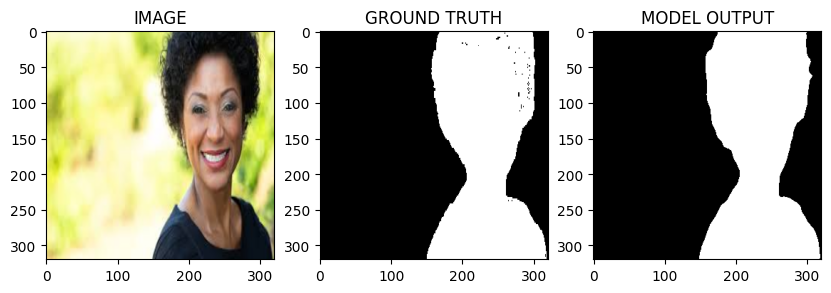

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya